In [2]:
import os
from collections import defaultdict

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'

from adjustText import adjust_text

from Bio import SeqIO

from scipy import stats
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
datadir = '../data/dnaPipeTE-out'
dnapipete_counts_data = {sp: f'{datadir}/{sp}/Counts.txt' for sp in os.listdir(datadir)}

In [4]:
def parse_dnapipete_coverage(countfile):
    coverage_df = pd.read_csv(countfile, sep='\t', header=None, names=['teclass', 'readcount'])
    return coverage_df

def parse_dnapipete_family_counts():
    dnapipete_annots_data = {}
    for sp in os.listdir(datadir):
        tedict = {}
        for teclass in ['DNA', 'Helitron', 'LINE', 'LTR', 'SINE', 'others']:
            i = 0
            with open(f'{datadir}/{sp}/Annotation/{teclass}.headers') as infile:
                for line in infile:
                    i += 1
            tedict[teclass] = i
        dnapipete_annots_data[sp] = tedict
    df = pd.DataFrame.from_dict(dnapipete_annots_data, orient='index') \
                     .reset_index() \
                     .rename({'index': 'species'}, axis=1)
    df['interspersed'] = df.sum(axis=1)
    return df 

def parse_rmodeller_out():
    rmlibs = {
    'Danio_aesculapii': 'fDanAes4.curated_primary.20190724.fa.align.parseRM.all-repeats.tab',
    'Danio_albolineatus': 'fDanAlb1.curated_primary.20190208.fa.align.parseRM.all-repeats.tab',
    'Danio_choprai': 'fDanCho1.curated_primary.20190226.fa.align.parseRM.all-repeats.tab',
    'Danionella_dracula': 'fDanDra1.1.fa.align.parseRM.all-repeats.tab',
    'Danio_jaintianensis': 'fDanJai1.curated_primary.20190227.fa.align.parseRM.all-repeats.tab',
    'Danio_kyathit': 'fDanKya3.curated_primary.20190802.fa.align.parseRM.all-repeats.tab',
    'Danio_tinwini': 'fDanTin1.curated_primary.20190226.fa.align.parseRM.all-repeats.tab',
    'Danionella_translucida': 'fDanTra1.curated_assembly.fa.align.parseRM.all-repeats.tab',
    'Danio_rerio': 'fDreABz2.toplevel_curated.20190410.fa.align.parseRM.all-repeats.tab'
    }
    data = {}
    for species, filename in rmlibs.items():
        tedict = defaultdict(int)
        with open(f'../data/repeatmasker-out/{filename}') as infile:
            infile.readline()
            infile.readline()
            for line in infile:
                line = line.split()
                tedict[line[1]] += 1
        data[species] = tedict
    df = pd.DataFrame.from_dict(data, orient='index') \
                     .reset_index() \
                     .rename({'index': 'species'}, axis=1)
    df['interspersed'] = df.sum(axis=1) 
    return df.sort_values('species')

def count_finz_znf(species):
    count = 0
    with open('../data/seqs/cypriniformes_augustus_finz.fa') as infile:
        for line in infile:
            if line.startswith(f'>{species}'):
                count += 1
    return count

def count_finz_exons(species):
    count = 0
    with open(f'../data/blast-out/{species}_finz_locs.out') as infile:
        for line in infile:
            count += 1
    return count

def count_znf_hits(species):
    count = 0
    with open(f'../data/blast-out/{species}_znf_locs.out') as infile:
        for line in infile:
            count += 1
    return count

def age_proportions():
    divdict = defaultdict(list)
    for species in dnapipete_counts_data.keys():
        landscape_df = pd.read_csv(f'../data/dnaPipeTE-out/{species}/reads_landscape', 
                                   sep=r'\s+', 
                                   header=None, 
                                   names=['identity', 'tename', 'tefam', 'teclass'])
        landscape_df['divergence'] = 100 - landscape_df.identity
        step = 5
        total = landscape_df.tename.count()
        divdict['species'].append(species)
        for i in range(0, int(np.ceil(max(landscape_df.divergence)))+1+step, step):
            divdict[f'lt_{i}'].append(landscape_df.loc[landscape_df.divergence <= i, 'tename'].count()/total)
            divdict[f'gt_{i}'].append(landscape_df.loc[landscape_df.divergence > i, 'tename'].count()/total)
    return pd.DataFrame.from_dict(divdict)

## Building genomic TE coverage dataframes

In [5]:
coverage_dfs = []
for sp, val in dnapipete_counts_data.items():
    coverage_df = parse_dnapipete_coverage(val)
    coverage_df['species'] = sp
    coverage_df['finz_znf'] = count_finz_znf(sp)
    coverage_df['finz_exons'] = count_finz_exons(sp)
    coverage_df['znf_hits'] = count_znf_hits(sp)
    coverage_dfs.append(coverage_df)

coverage_df = pd.concat(coverage_dfs)
coverage_df = coverage_df.pivot_table(index=['species', 'finz_exons', 'finz_znf', 'znf_hits'], 
                                columns='teclass', 
                                values='readcount') \
    .sort_values('finz_znf') \
    .reset_index()
coverage_df['Unknown'] = coverage_df.na + coverage_df.others
coverage_df = coverage_df.drop(['Others', 'Tandem_repeats', 'na', 'others', 'rRNA', 'MITE', 'Simple_repeat'], axis=1)
coverage_df['interspersed'] = coverage_df.DNA + coverage_df.LTR + coverage_df.LINE + coverage_df.SINE + coverage_df.Helitron + coverage_df.Unknown
    
for teclass in ['DNA', 'Helitron', 'LINE', 'LTR', 'SINE', 'Low_Complexity', 'Satellite', 'Unknown', 'interspersed', 'Total']:
    coverage_df[teclass] = coverage_df[teclass]/coverage_df['Total']*100

with open('../data/species_genomes.txt') as infile:
    hiqual = [line.split()[0] for line in infile]
coverage_df = coverage_df.loc[coverage_df.species.isin(hiqual)]
coverage_df.to_csv('../data/finz_te_coverage.txt', sep='\t', index=False)

# The remaining dataframes are partially constructed off the back of the main coverage_df, or generated in R, as is the case for the pic_dfs.
counts_df = parse_dnapipete_family_counts()
counts_df = counts_df.merge(coverage_df[['species', 'finz_exons', 'finz_znf', 'znf_hits']], on='species', how='inner')

rmodeller_df = parse_rmodeller_out()
rmodeller_df = rmodeller_df.merge(coverage_df[['species', 'finz_znf', 'finz_exons', 'znf_hits']], on='species', how='inner')
rmodeller_df.to_csv('../data/finz_te_counts.txt', sep='\t', index=False)

pic_coverage_df = pd.read_csv('../data/finz_pics.txt', sep='\t')
pic_rmodeller_df = pd.read_csv('../data/finz_pics.txt', sep='\t')

/Users/jonwells/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/Users/jonwells/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


NameError: name 'pic_df' is not defined

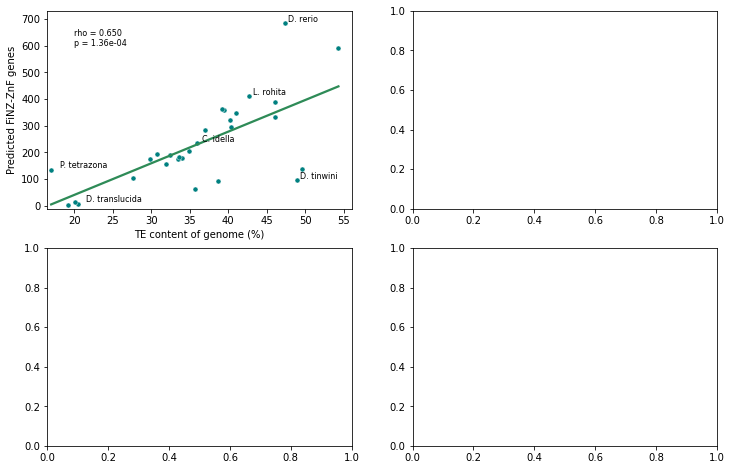

In [6]:
column = 'interspersed'
column2 = 'finz_znf'
dataframe = coverage_df.loc[(~coverage_df.species.str.startswith('Chanos')) & (~coverage_df.species.str.startswith('Triplophysa'))]
dataframe2 = rmodeller_df

# Define 2x2 grid
fig, ax = plt.subplots(figsize=(12, 8), ncols=2, nrows=2)

###############################################################################
## Plot panel A: Regression plot of genomic TE coverage and FiNZ-ZnF count
###############################################################################

sns.regplot(data=dataframe, 
            x=column, 
            y=column2,
            scatter=False,
            ci=None,
            color='seagreen',
            ax=ax[0][0])

sns.scatterplot(data=dataframe, 
                x=column, 
                y=column2,
                color='teal',
                s=25,
                ax=ax[0][0])

ax[0][0].set_xlim(16.5, 56)
ax[0][0].set_ylim(-10, 730)
ax[0][0].set_xlabel('TE content of genome (%)')
ax[0][0].set_ylabel('Predicted FiNZ-ZnF genes')

labels = []
for row in dataframe.iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    if label not in ['D. rerio', 'D. tinwini', 'P. tetrazona', 'L. rohita', 'C. idella', 'D. translucida', 'P. huangchuchieni']:
        continue
    labels.append(ax[0][0].text(row[1][column], row[1][column2], 
                             label, 
                             fontsize=8, 
                             va='center', 
                             ha='center'))
adjust_text(labels)

pval = stats.spearmanr(dataframe[column], 
                       dataframe[column2])
ax[0][0].text(x=20, 
        y=600, 
        s=f'rho = {pval[0]:.3f}\np = {pval[1]:.2e}',
        fontsize=8)

###############################################################################
## Plot panel B: Phylogenetically independents contrasts of genomic TE coverage
## and FiNZ-ZnF count.
###############################################################################

sns.regplot(data=pic_df, 
            x=f'pic.{column}', 
            y='pic.finz_znf',
            scatter=False,
            ci=None,
            color='seagreen',
            ax=ax[0][1])

sns.scatterplot(data=pic_df, 
                x=f'pic.{column}', 
                y='pic.finz_znf',
                color='teal',
                s=25,
                ax=ax[0][1])


ax[0][1].set_xlim(-70, 110)
ax[0][1].set_xlabel('Contrast in TE content')
ax[0][1].set_ylabel('Contrast in FiNZ-ZnF copy number')

picpval = stats.spearmanr(pic_df[f'pic.{column}'], 
                       pic_df['pic.finz_znf'])

ax[0][1].text(x=-50, 
           y=2000, 
           s=f'rho = {picpval[0]:.3f}\np = {picpval[1]:.2e}',
           fontsize=8)

###############################################################################
## Plot panel C: Correlation between predicted numbers of TE families and
## FiNZ-ZnF genes within Danioninae species.
###############################################################################

sns.scatterplot(data=dataframe2, 
                x=column, 
                y=column2,
                color='teal',
                s=25,
                ax=ax[1][0])
labels = []
for row in dataframe2.iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax[1][0].text(row[1][column], row[1][column2], 
                             label, 
                             fontsize=8, 
                             va='bottom', 
                             ha='left'))


sns.despine()
plt.show()
fig.savefig('../figs/finz_znf_corr.pdf', bbox_inches='tight', dpi=300)

A possible explanation for some of the noise in the correlation is genome assembly quality. Since the finz-znfs are normally present on specific, highly repetitive chromosomes, it is possible that low numbers of predicted genes could be due to collapsing or fragmentation of these regions. To test this, we will look at the correlation between N50 and finz count.

In [48]:
def calc_N50(genomefile):
    contiglens = []
    for record in SeqIO.parse(genomefile, 'fasta'):
        contiglens.append(len(record.seq))
    contiglens = sorted(contiglens, reverse=True)
    gsize = sum(contiglens)
    i, currentsize = 0, 0
    while currentsize <= gsize*0.5:
        currentsize += contiglens[i]
        i += 1
    return contiglens[i]

with open('../data/species_genomes.txt') as infile:
    genomes = {line.split()[0]: f'/Users/jonwells/Genomes/Cypriniformes/{line.split()[1]}' for line in infile}
genomes.pop('Chanos_chanos')


n50s = []
for species, genomefile in genomes.items():
    n50s.append((species, calc_N50(genomefile)))
n50_df = pd.DataFrame(n50s, columns=['species', 'N50'])
# n50_df = n50_df.merge(coverage_df, on='species')
print(n50_df.head())

                        species      N50
0               Cyprinus_carpio  7653411
1       Ctenopharyngodon_idella  6014843
2  Sinocyclocheilus_anshuiensis  1282074
3  Sinocyclocheilus_rhinocerous   945578
4      Sinocyclocheilus_grahami  1156011


In [49]:
n50_df = n50_df[['species', 'N50']]
n50_df = n50_df.merge(coverage_df, on='species')
print(n50_df)
n50_df.to_csv('../data/finz_te_counts.txt', sep='\t', header=True, index=False)

                            species       N50  finz_exons  finz_znf  znf_hits  \
0                   Cyprinus_carpio   7653411         523       157     19747   
1           Ctenopharyngodon_idella   6014843         341       235     10221   
2      Sinocyclocheilus_anshuiensis   1282074         400       195     11938   
3      Sinocyclocheilus_rhinocerous    945578         415       176      8832   
4          Sinocyclocheilus_grahami   1156011         550       174     11668   
5   Sinocyclocheilus_maitianheensis   1358641         390       189     11739   
6     Sinocyclocheilus_anophthalmus    309865         498       179     10597   
7                 Carassius_auratus  21934901         334       183     17005   
8          Oxygymnocypris_stewartii    256525         280       137     17186   
9               Anabarilius_grahami   4449300         547       294      9146   
10                     Labeo_rohita   1954488         715       410     14558   
11                      Labe

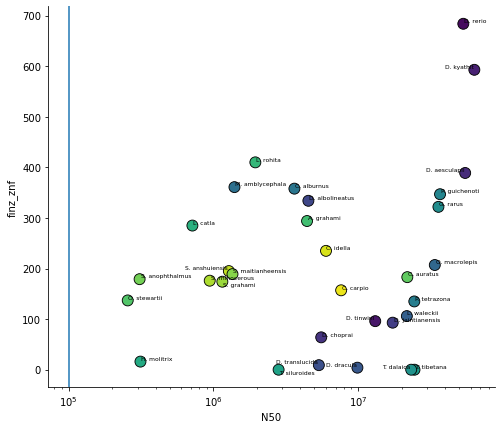

SpearmanrResult(correlation=0.15621563206541905, pvalue=0.3932212757310306)
SpearmanrResult(correlation=0.17375366568914952, pvalue=0.34157669639498467)


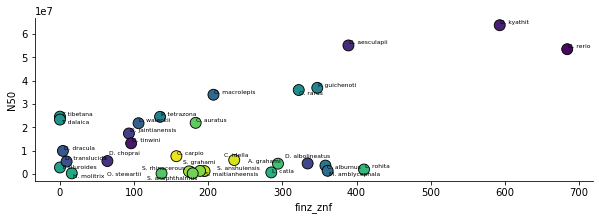

SpearmanrResult(correlation=0.15621563206541905, pvalue=0.3932212757310306)


In [66]:
min_N50 = 1e05
column = 'finz_znf'

fig, ax = plt.subplots(figsize=(8, 7)) 
sns.scatterplot(data=n50_df, 
                x='N50', 
                y=column,
                hue='species',
                palette='viridis_r',
                edgecolor='k',
                s=120,
                ax=ax)
ax.axvline(x=min_N50)
ax.set_xscale('log')
ax.get_legend().remove()

labels = []
for row in n50_df.iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax.text(row[1]['N50'], row[1][column], label, size=6, va='center', ha='center'))
adjust_text(labels)

sns.despine()
plt.show()
print(stats.spearmanr(n50_df.loc[n50_df['N50'] >= min_N50].N50, n50_df.loc[n50_df['N50'] >= min_N50][column]))
print(stats.spearmanr(n50_df.loc[n50_df['N50'] >= min_N50].N50, n50_df.loc[n50_df['N50'] >= min_N50].interspersed))

fig, ax = plt.subplots(figsize=(10, 3)) 
sns.scatterplot(data=n50_df.loc[n50_df['N50'] >= min_N50], 
                y='N50', 
                x=column,
                hue='species',
                palette='viridis_r',
                edgecolor='k',
                s=120,
                ax=ax)
ax.get_legend().remove()

labels = []
for row in n50_df.loc[n50_df['N50'] >= min_N50].iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax.text(row[1][column], row[1]['N50'], label, size=6, va='center', ha='center'))
adjust_text(labels)

sns.despine()
plt.show()

print(stats.spearmanr(n50_df.loc[n50_df['N50'] >= min_N50].N50, n50_df.loc[n50_df['N50'] >= min_N50][column]))

In [23]:
print(n50_df.loc[n50_df['N50'] >= min_N50].reset_index().species)
n50_df.loc[n50_df['N50'] >= min_N50].reset_index()[['species']].to_csv('../data/n50_gt5e05.txt', header=False, index=False)

0                     Cyprinus_carpio
1             Ctenopharyngodon_idella
2        Sinocyclocheilus_anshuiensis
3        Sinocyclocheilus_rhinocerous
4            Sinocyclocheilus_grahami
5     Sinocyclocheilus_maitianheensis
6       Sinocyclocheilus_anophthalmus
7                   Carassius_auratus
8            Oxygymnocypris_stewartii
9                 Anabarilius_grahami
10                       Labeo_rohita
11                        Labeo_catla
12        Hypophthalmichthys_molitrix
13                  Gobiocypris_rarus
14         Paracanthobrama_guichenoti
15                Puntigrus_tetrazona
16                    Culter_alburnus
17           Megalobrama_amblycephala
18             Onychostoma_macrolepis
19                 Leuciscus_waleckii
20                 Danionella_dracula
21             Danionella_translucida
22                 Danio_albolineatus
23                Danio_jaintianensis
24                      Danio_choprai
25                   Danio_aesculapii
26          

In [94]:
def parse_rmodeller_out():
    rmlibs = {
    'Danio_aesculapii': 'fDanAes4.curated_primary.20190724.fa.align.parseRM.all-repeats.tab',
    'Danio_albolineatus': 'fDanAlb1.curated_primary.20190208.fa.align.parseRM.all-repeats.tab',
    'Danio_choprai': 'fDanCho1.curated_primary.20190226.fa.align.parseRM.all-repeats.tab',
    'Danionella_dracula': 'fDanDra1.1.fa.align.parseRM.all-repeats.tab',
    'Danio_jaintianensis': 'fDanJai1.curated_primary.20190227.fa.align.parseRM.all-repeats.tab',
    'Danio_kyathit': 'fDanKya3.curated_primary.20190802.fa.align.parseRM.all-repeats.tab',
    'Danio_tinwini': 'fDanTin1.curated_primary.20190226.fa.align.parseRM.all-repeats.tab',
    'Danionella_translucida': 'fDanTra1.curated_assembly.fa.align.parseRM.all-repeats.tab',
    'Danio_rerio': 'fDreABz2.toplevel_curated.20190410.fa.align.parseRM.all-repeats.tab'
    }
    data = {}
    for species, filename in rmlibs.items():
        tedict = defaultdict(int)
        with open(f'../data/repeatmasker-out/{filename}') as infile:
            infile.readline()
            infile.readline()
            for line in infile:
                line = line.split()
                tedict[line[1]] += 1
        data[species] = tedict
    df = pd.DataFrame.from_dict(data, orient='index') \
                     .reset_index() \
                     .rename({'index': 'species'}, axis=1)
    df['interspersed'] = df.sum(axis=1) 
    return df.sort_values('species')

                  species   DNA  LINE  LTR  Unknown  SINE  Retroposon  RC  \
0        Danio_aesculapii  1970   343  539      548    30          11  34   
1      Danio_albolineatus  1840   330  464      577    33           9  34   
2           Danio_choprai  1429   259  249      690    25          12  29   
3     Danio_jaintianensis  1530   288  396      730    33          14  41   
4           Danio_kyathit  1993   320  925      554    32          10  48   
5             Danio_rerio  2037   345  388      472    28          15  44   
6           Danio_tinwini  1893   347  362      537    23           6  39   
7      Danionella_dracula   644   252  367     1139    27          10  26   
8  Danionella_translucida   843   155  177     1306    19           8  43   

   SINE?  interspersed  finz_znf  finz_exons  
0    NaN        3475.0       389         439  
1    1.0        3288.0       334         563  
2    NaN        2693.0        64          92  
3    NaN        3032.0        93         

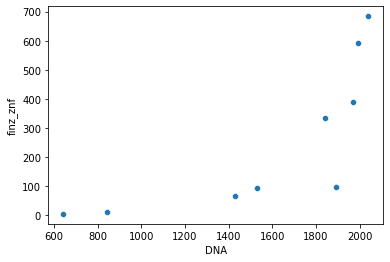

In [97]:
rmodeller_df = parse_rmodeller_out()
rmodeller_df = rmodeller_df.merge(coverage_df[['species', 'finz_znf', 'finz_exons']], on='species', how='inner')
print(rmodeller_df)
sns.scatterplot(data=rmodeller_df, x='DNA', y='finz_znf')
print(stats.spearmanr(rmodeller_df.DNA, rmodeller_df.finz_znf))